In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [11]:
x_ray_director="C:/Users/User/Downloads/Dataset"

In [13]:
os.listdir(x_ray_director)

['0', '1', '2', '3']

In [15]:
image_generator=ImageDataGenerator(rescale=1/225.0,validation_split=0.2)

In [17]:
train_generator=image_generator.flow_from_directory(batch_size=40,directory=x_ray_director, shuffle=True, target_size=(256,256), class_mode='categorical', subset='training')

Found 428 images belonging to 4 classes.


In [19]:
validation_generator=image_generator.flow_from_directory(batch_size=40,directory=x_ray_director, shuffle=True, target_size=(256,256), class_mode='categorical', subset='validation')

Found 104 images belonging to 4 classes.


In [21]:
train_images,train_labels=next(train_generator)

In [23]:
train_images.shape

(40, 256, 256, 3)

In [25]:
train_labels.shape

(40, 4)

In [27]:
label_names={0:'Covid 19', 1:'Normal', 2:'Viral Pneumonia', 3:'Bacterial Pneumonia'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.24000001..1.1333333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0711111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1333333].
Clipping input data to the 

AttributeError: module 'matplotlib.pyplot' has no attribute 'subplot_adjust'

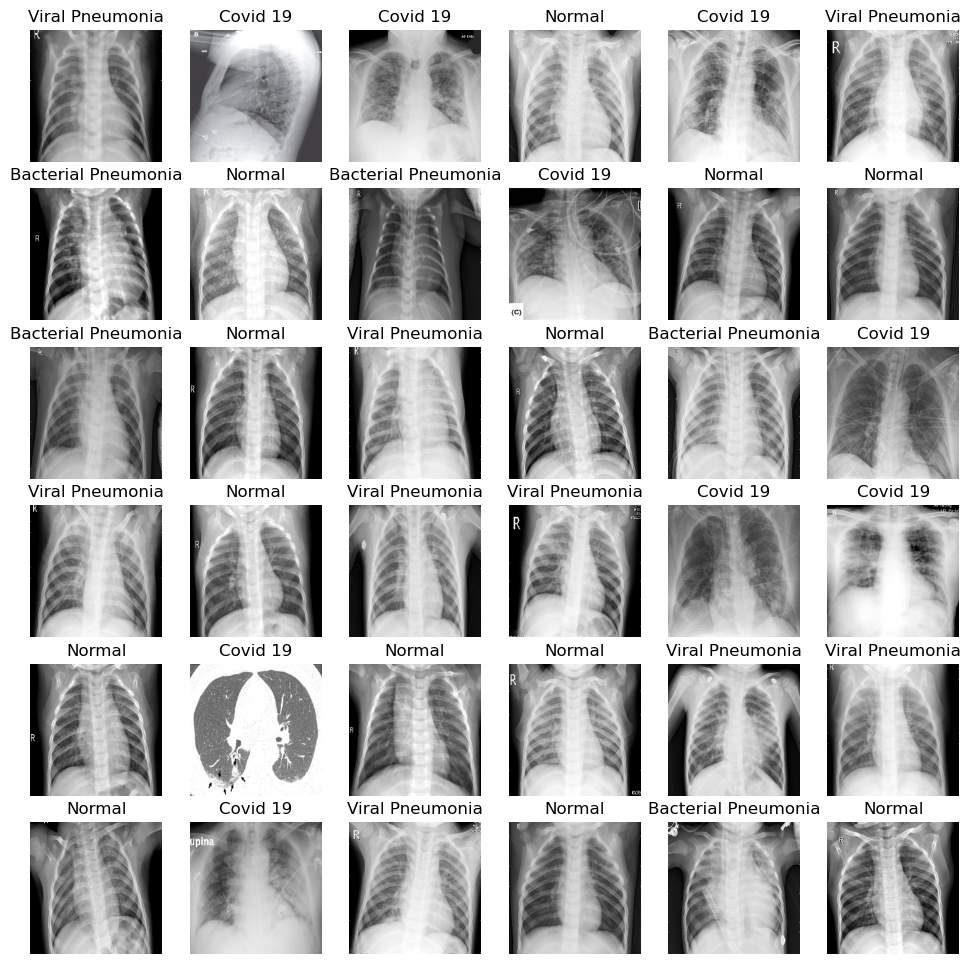

In [39]:
l=6
w=6
fig,axes=plt.subplots(l,w,figsize=(12,12))
axes= axes.ravel()

for i in np.arange(0,l*w):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplot_adjust(wspace=0.5)

In [41]:
basemodel= ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 82s 1us/step


In [43]:
for layer in basemodel.layers[:-10]:
    layers.trainable= False
    

In [45]:
headmodel= basemodel.output
headmodel= AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel=Flatten(name="flatten")(headmodel)
headmodel= Dense(256, activation='relu')(headmodel)
headmodel= Dropout(0.3)(headmodel)
headmodel= Dense(128, activation='relu')(headmodel)
headmodel= Dropout(0.2)(headmodel)
headmodel= Dense(4, activation='softmax')(headmodel)

In [47]:
model = Model(inputs=basemodel.input, outputs=headmodel)

In [53]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

In [63]:
earlystopping= EarlyStopping(monitor='val_loss', mode='min', patience=20)
checkpointer= ModelCheckpoint(filepath='weights.keras', verbose=1, save_best_only= True)

In [65]:
train_generator= image_generator.flow_from_directory(batch_size=4, directory=x_ray_director, shuffle=True, target_size=(256,256),class_mode='categorical', subset='training')
validation_generator= image_generator.flow_from_directory(batch_size=4, directory=x_ray_director, shuffle=True, target_size=(256,256),class_mode='categorical', subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [69]:
history= model.fit(train_generator, epochs=5, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


C:\Users\User\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5131 - loss: 1.1432
Epoch 1: val_loss improved from inf to 2.72955, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.5146 - loss: 1.1405 - val_accuracy: 0.2500 - val_loss: 2.7295
Epoch 2/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8617 - loss: 0.4559
Epoch 2: val_loss did not improve from 2.72955
107/107 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.8617 - loss: 0.4558 - val_accuracy: 0.2500 - val_loss: 3.8990
Epoch 3/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9420 - loss: 0.2181
Epoch 3: val_loss did not improve from 2.72955
107/107 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9419 - loss: 0.2183 - val_accuracy: 0.2500 - val_loss: 7.4747
Epoch 4/5
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8979 - loss: 0.3066
Epoch 4: val_loss did not improve from 2.72955
107/107 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.8979 - loss: 0.3071 - val_accuracy: 0.2500 - 

In [71]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

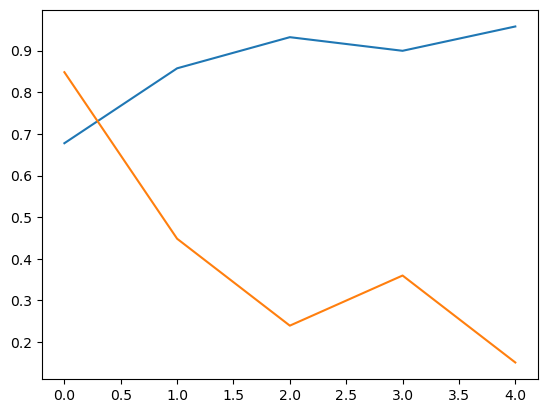

In [73]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

Text(0.5, 0, 'epochs')

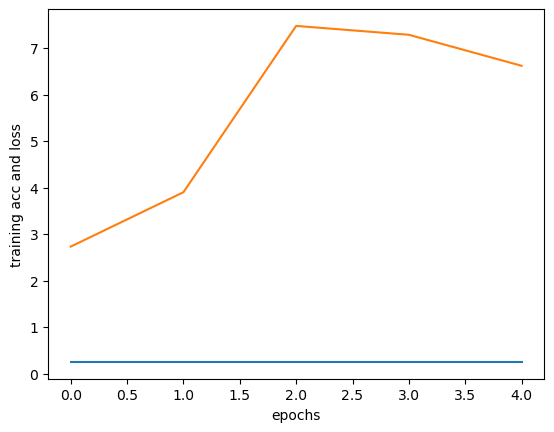

In [79]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.ylabel('training acc and loss')
plt.xlabel('epochs')

In [81]:
#mess with the layers to get different layers and all and also increase the no of epochs by 25

In [91]:
test_directory= "C:/Users/User/Downloads/Test"

In [93]:
test_gen=ImageDataGenerator(rescale=1./255)

In [95]:
test_generator=test_gen.flow_from_directory(batch_size=40, directory=test_directory, shuffle=True , target_size=(256,256), class_mode='categorical')

Found 40 images belonging to 4 classes.


In [99]:
evaluate=model.evaluate(test_generator, steps=test_generator.n//4, verbose=1)
print('accuracy test:{}'.format(evaluate[1]))

C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2500 - loss: 6.5320
accuracy test:0.25


C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [101]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [111]:
prediction=[]
original=[]
image=[]
for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img=cv2.imread(os.path.join(test_directory, str(i), item))
        img=cv2.resize(img,(256,256))
        image.append(img)
        img=img/255
        img=img.reshape(-1, 256, 256, 3)
        predict=model.predict(img)
        predict=np.argmax(predict)
        prediction.append(predict)
        original.append(i)

C:\Users\User\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [113]:
score=accuracy_score(original,prediction)
print('test acc:{}'.format(score))

test acc:0.25


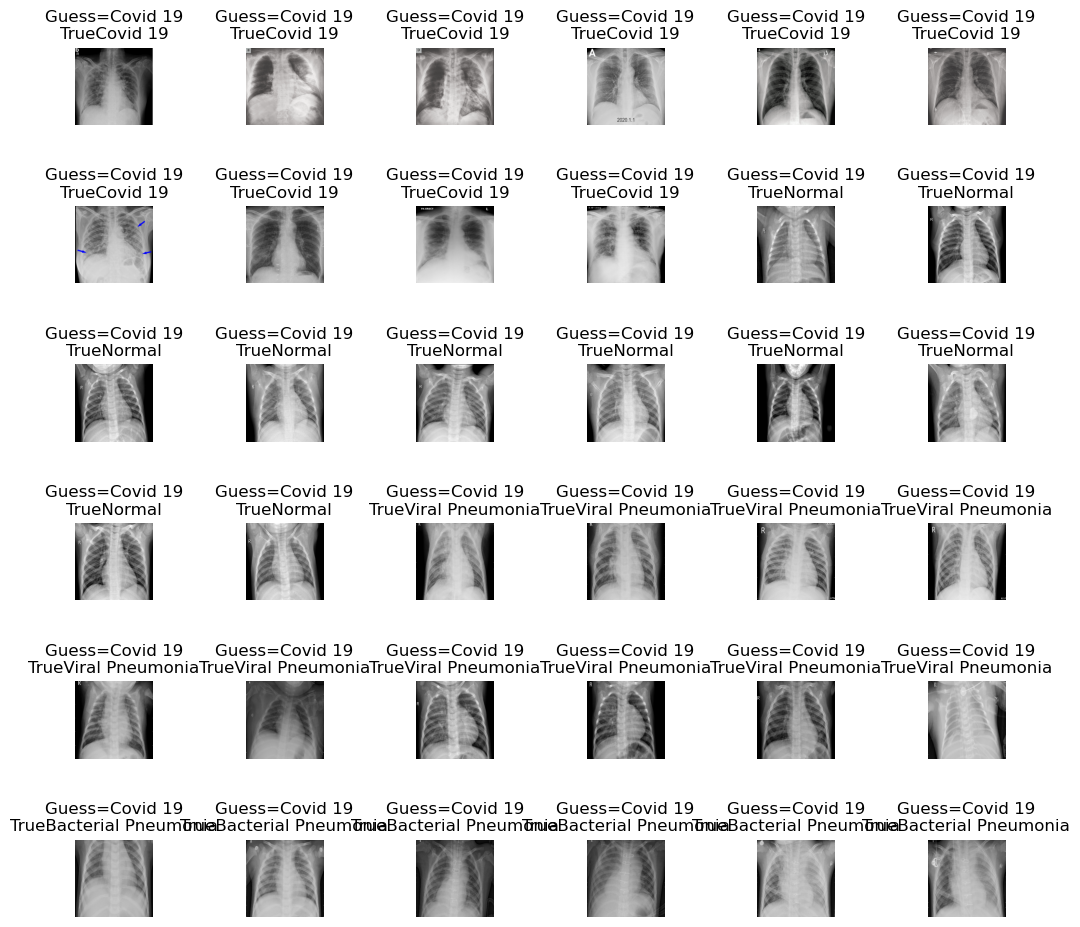

In [121]:
l=6
w=6
fig, axes= plt.subplots(l,w,figsize=(12,12))
axes=axes.ravel()

for i in np.arange(0, l*w):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue{}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('Off')

plt.subplots_adjust(wspace=1.2)

In [123]:
print(classification_report)

<function classification_report at 0x0000016612019A80>
